# House Prices Prediction.

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso

plt.rcParams['figure.figsize'] = (10.0, 8.0)

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Exploratory Data Analysis

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

We have 80 variables, 79 predictor variables and 1 target variable (SalePrice).

In [ ]:
train['SalePrice'].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

The max value of SalePrice is far higher than the 75th percentile. So we expect the distribution of SalePrice to have a longer tail to the right.

1.8828757597682129


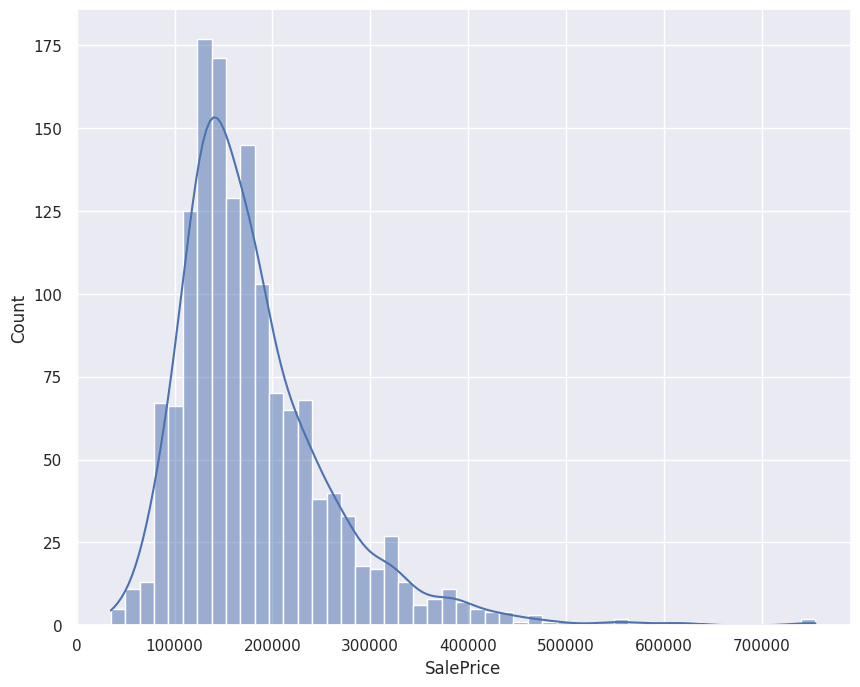

In [ ]:
print(train['SalePrice'].skew())
sns.histplot(train['SalePrice'], kde=True);

We're right, the SalePrice is positively skewed. We'll later transform it to make it more normally distributed.

For now, let's explore the numerical variables in our data.

### Numerical Variables

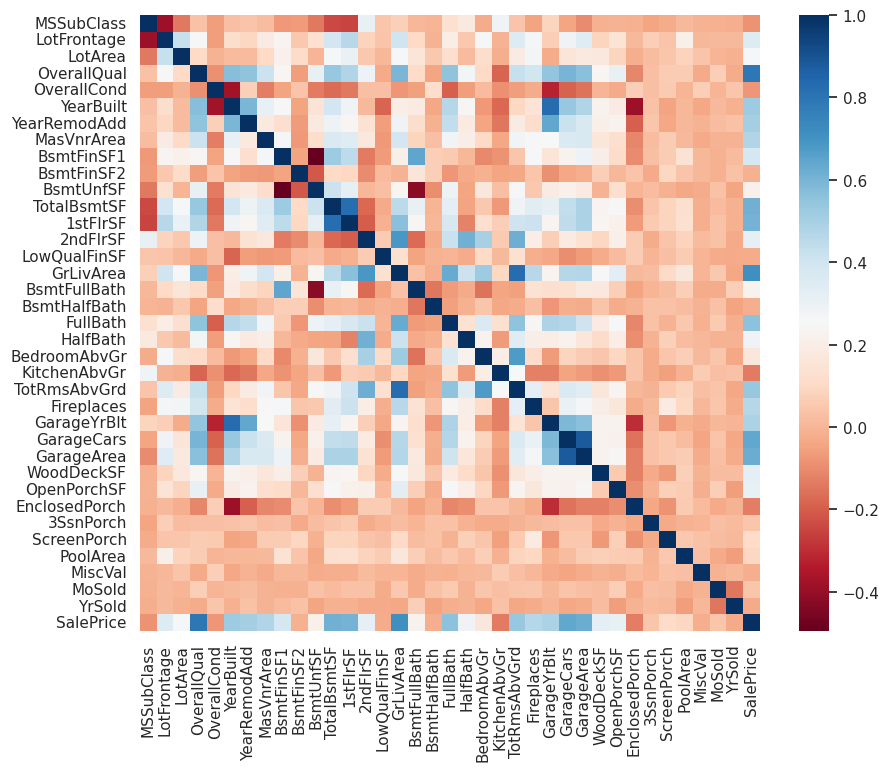

In [ ]:
num_data = train.select_dtypes(include=[np.number])
num_data.drop(['Id'], axis=1, inplace=True)

corr_mat = num_data.corr()
sns.heatmap(corr_mat, cmap='RdBu');

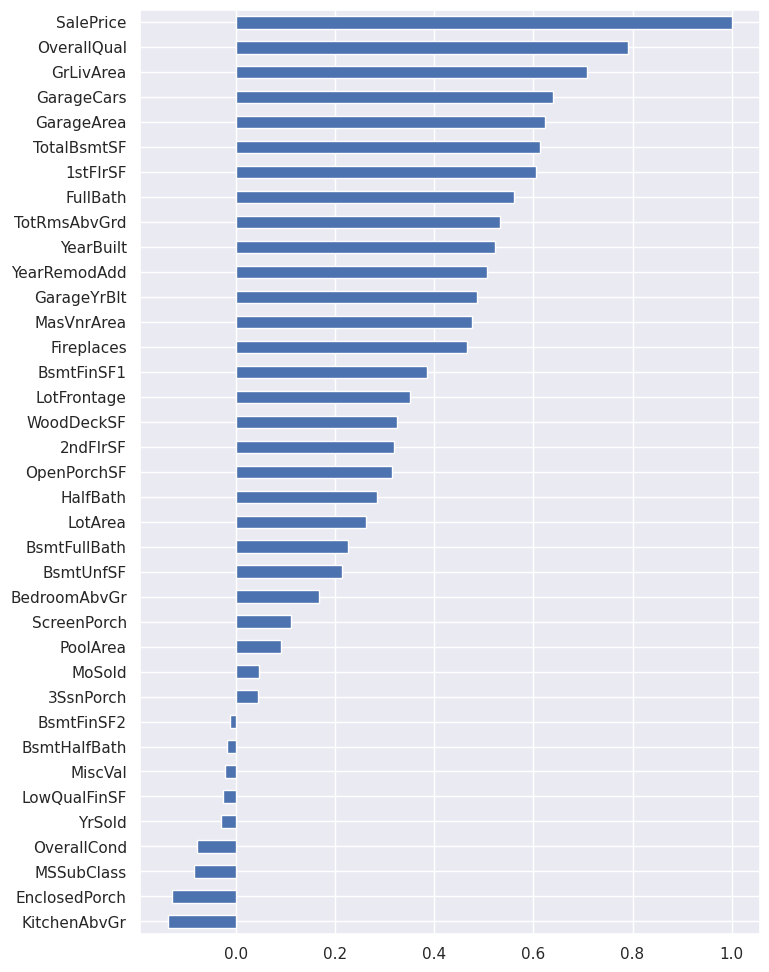

In [ ]:
plt.figure(figsize=(8, 12))
corr_mat['SalePrice'].sort_values().plot(kind='barh');

As shown in the plot, some variables are highly correlated to the SalePrice, meaning that if their value go up, so does the SalePrice. Some of these variables are OverallQual, GrLivArea, GarageCars, GarageArea, TotalBsmtSF, and 1stFlrSF.

Let's explore these variables individually.

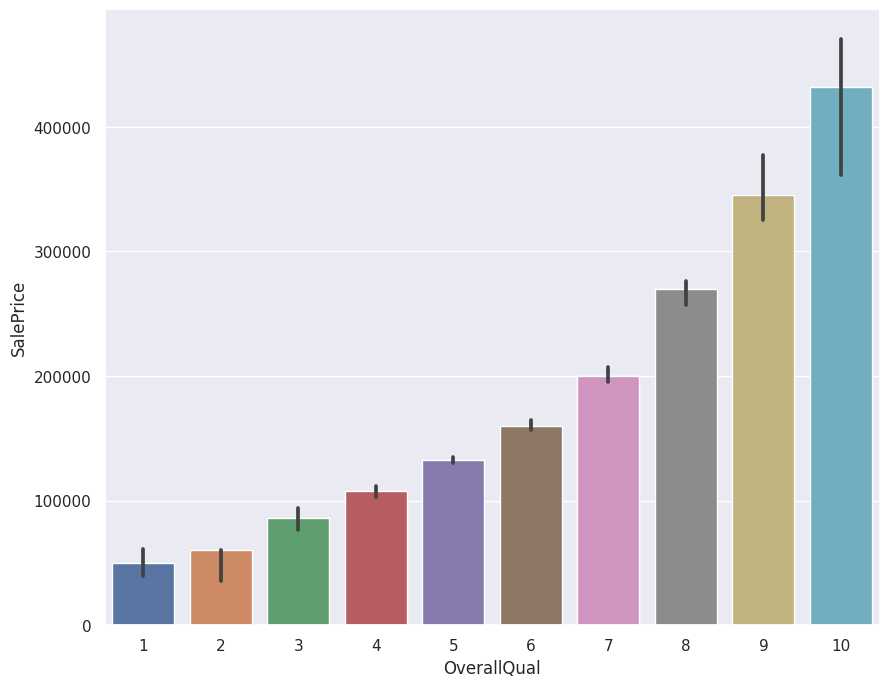

In [ ]:
sns.barplot(data=train, x='OverallQual', y='SalePrice', estimator='median');

The higher the quality of the house, the better the SalePrice. That makes sense!

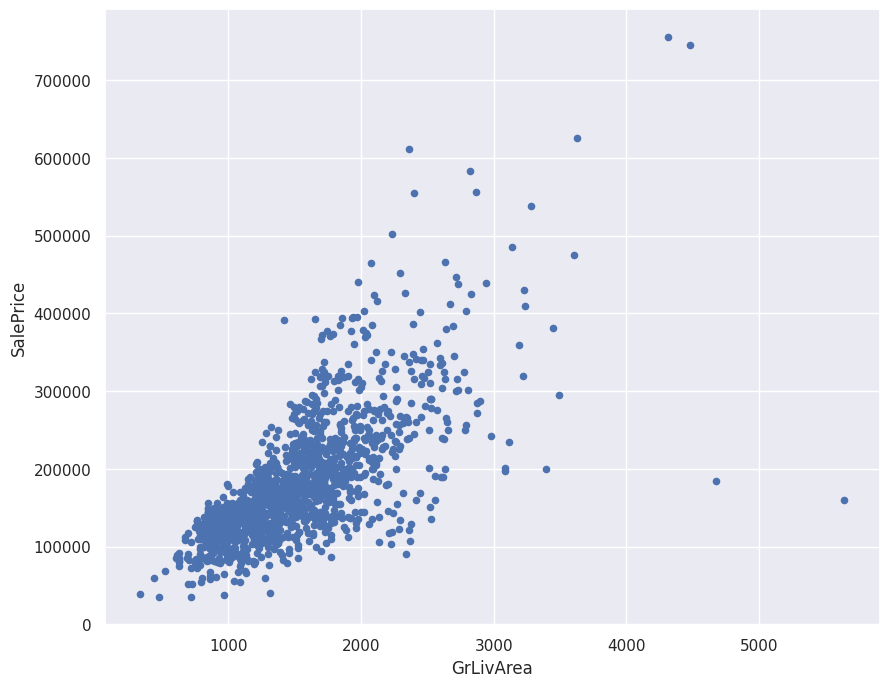

In [ ]:
train.plot(x='GrLivArea', y='SalePrice', kind='scatter');

From above plot, we can see the linear relationship between variable GrLivArea and SalePrice, except the two outliers when the GrLivArea is more than 4500. We'll deal with these two later.

We can also see similar pattern of relationship of the variables below with the SalePrice.

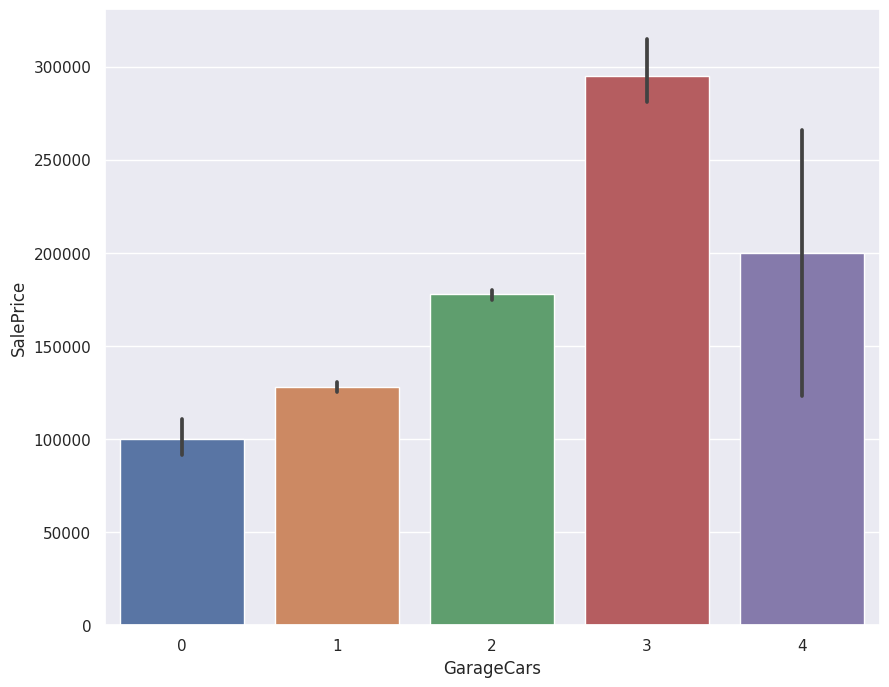

In [ ]:
sns.barplot(data=train, x='GarageCars', y='SalePrice', estimator='median');

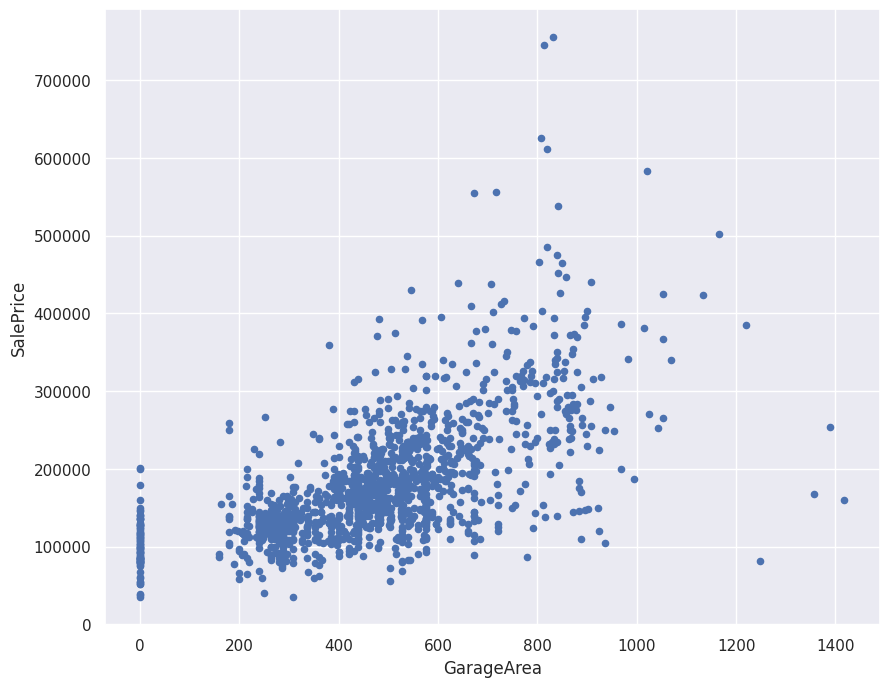

In [ ]:
train.plot(x='GarageArea', y='SalePrice', kind='scatter');

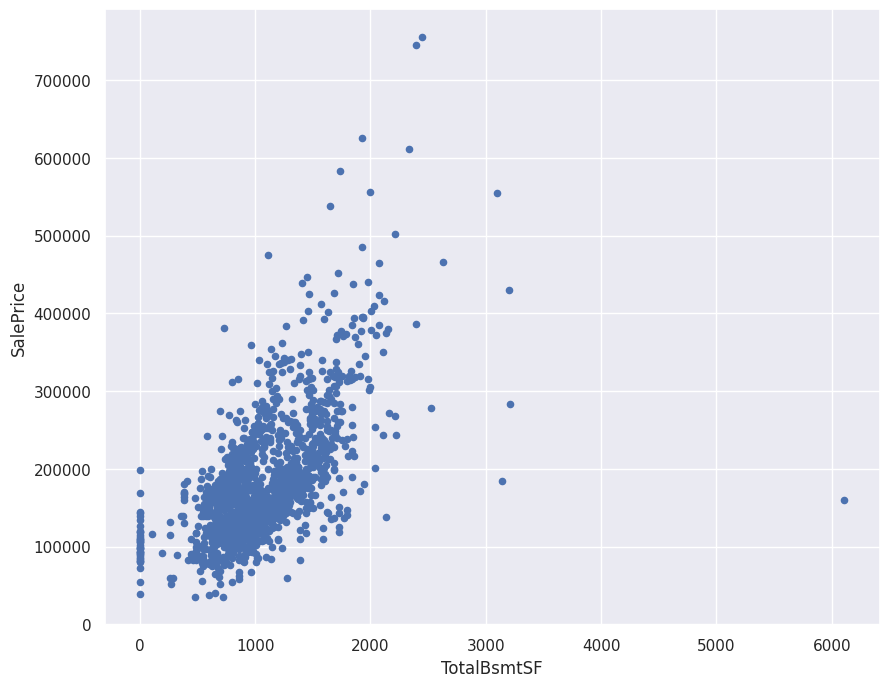

In [ ]:
train.plot(x='TotalBsmtSF', y='SalePrice', kind='scatter');

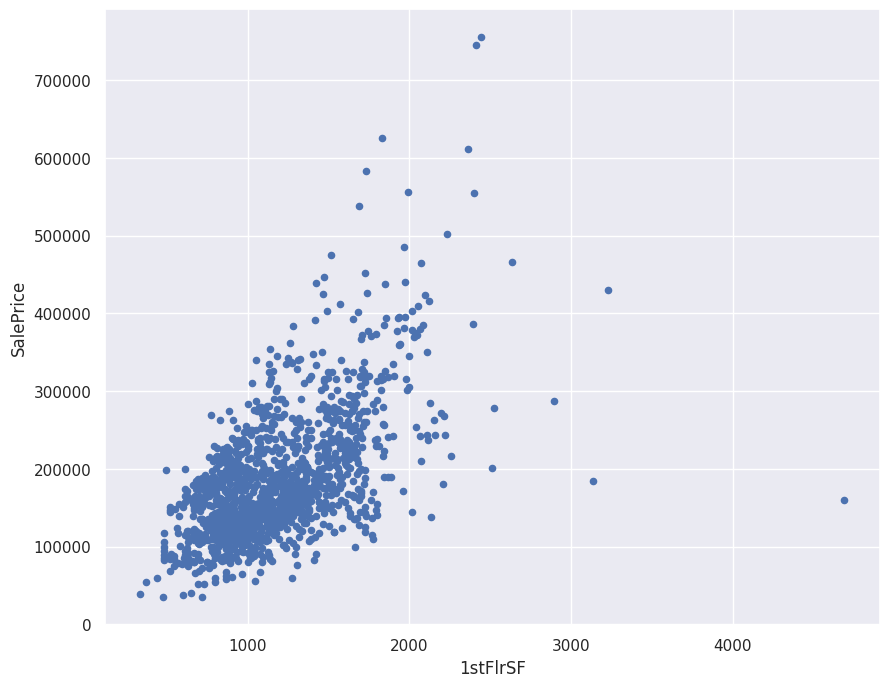

In [ ]:
train.plot(x='1stFlrSF', y='SalePrice', kind='scatter');

Next, let's explore the categical variables in our data.

### Categorical Variables

In [ ]:
cat_data = train.select_dtypes(exclude=[np.number])
cat_data.describe().T

,count,unique,top,freq
MSZoning,1460,5,RL,1151
Street,1460,2,Pave,1454
Alley,91,2,Grvl,50
LotShape,1460,4,Reg,925
LandContour,1460,4,Lvl,1311
Utilities,1460,2,AllPub,1459
LotConfig,1460,5,Inside,1052
LandSlope,1460,3,Gtl,1382
Neighborhood,1460,25,NAmes,225
Condition1,1460,9,Norm,1260


We'll do ANOVA test to see the relationship of our categorical variables with the SalePrice.

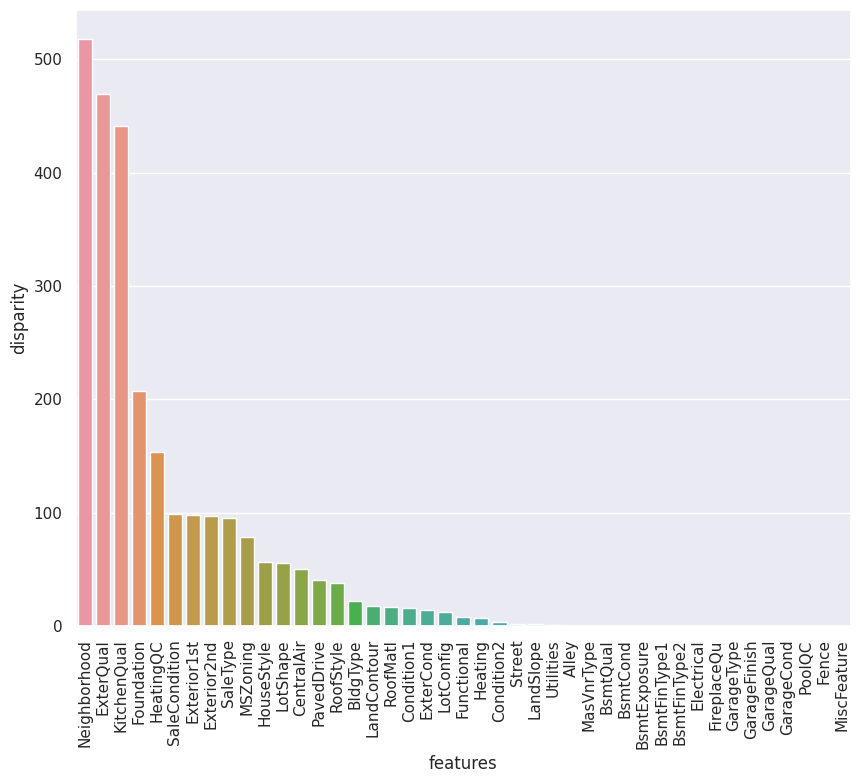

In [ ]:
def anova(df, columns):
    anv = pd.DataFrame()
    anv['features'] = columns
    pvals = []

    for c in columns:
        samples = []
        for cls in df[c].unique():
            s = df[df[c] == cls]['SalePrice'].values
            samples.append(s)
        if any(len(s) == 0 for s in samples):
            pval = np.nan
        else:
            pval = stats.f_oneway(*samples)[1]
        pvals.append(pval)
    anv['pval'] = pvals
    anv['disparity'] = np.log(1. / anv['pval'])
    return anv.sort_values('disparity', ascending=False)

cat = cat_data.columns.to_list()
cat_data['SalePrice'] = train['SalePrice'].values
k = anova(cat_data, cat)

sns.barplot(data=k, x='features', y='disparity')
plt.xticks(rotation=90);

Let's explore some of these variables.

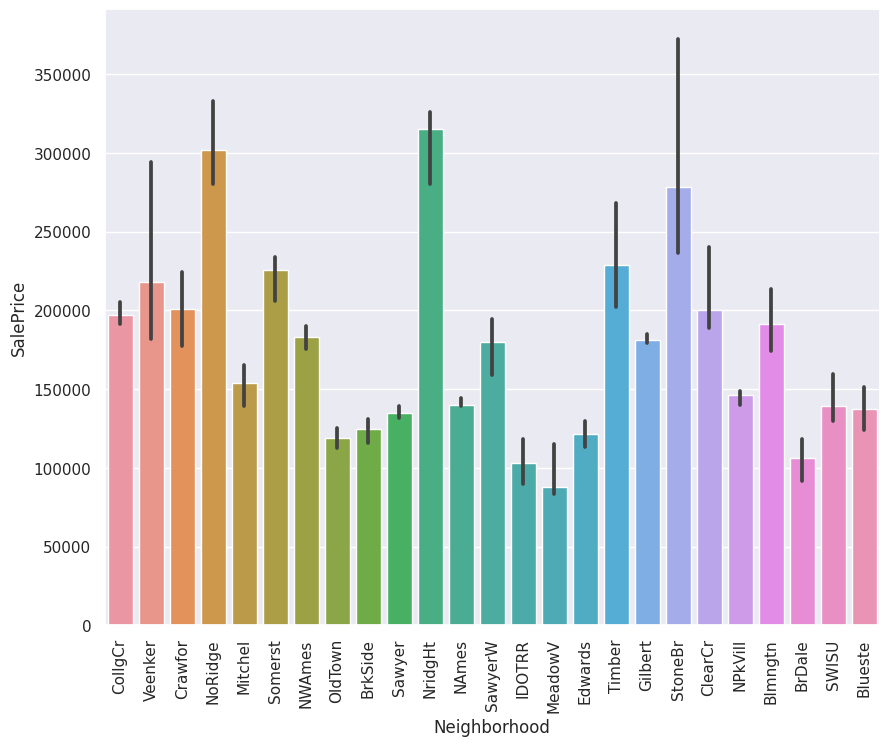

In [ ]:
sns.barplot(data=train, x='Neighborhood', y='SalePrice', estimator='median')
plt.xticks(rotation=90);

Houses in certain neighborhoods are more expensive than the others. The most expensive one is in NridgHt, followed by NoRidge and StoneBr.

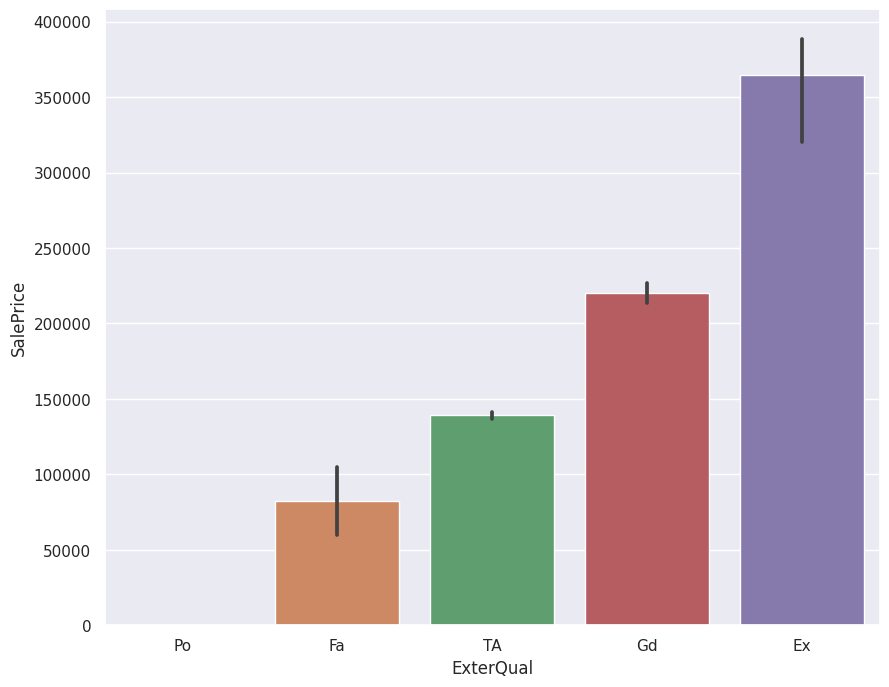

In [ ]:
sns.barplot(data=train, x='ExterQual', y='SalePrice', estimator='median', order=['Po', 'Fa', 'TA', 'Gd', 'Ex']);

The better the ExterQual (Exterior), the higher the SalePrice.

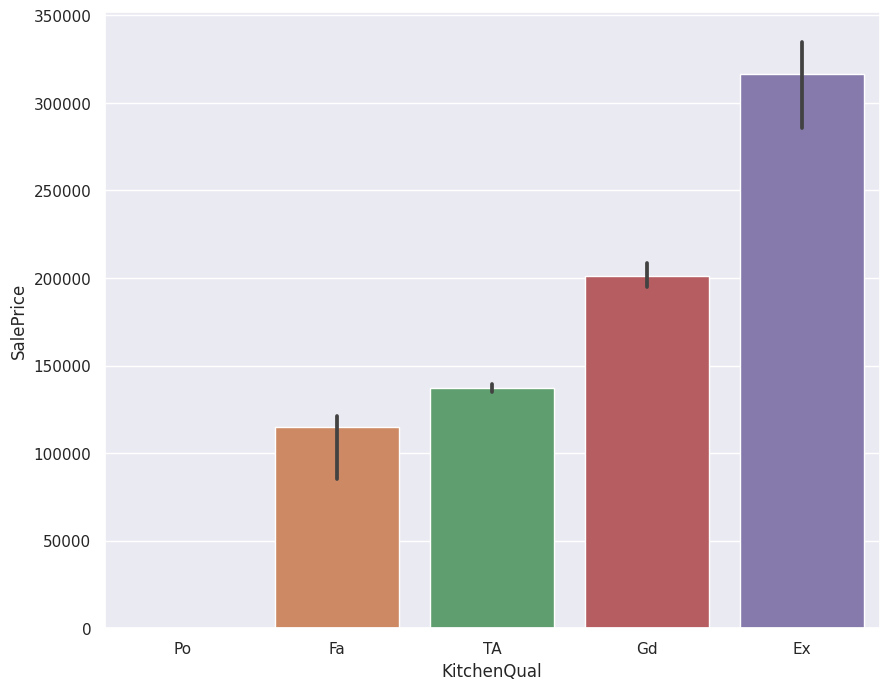

In [ ]:
sns.barplot(data=train, x='KitchenQual', y='SalePrice', estimator='median', order=['Po', 'Fa', 'TA', 'Gd', 'Ex']);

The same relationship also applies to KitchenQual.

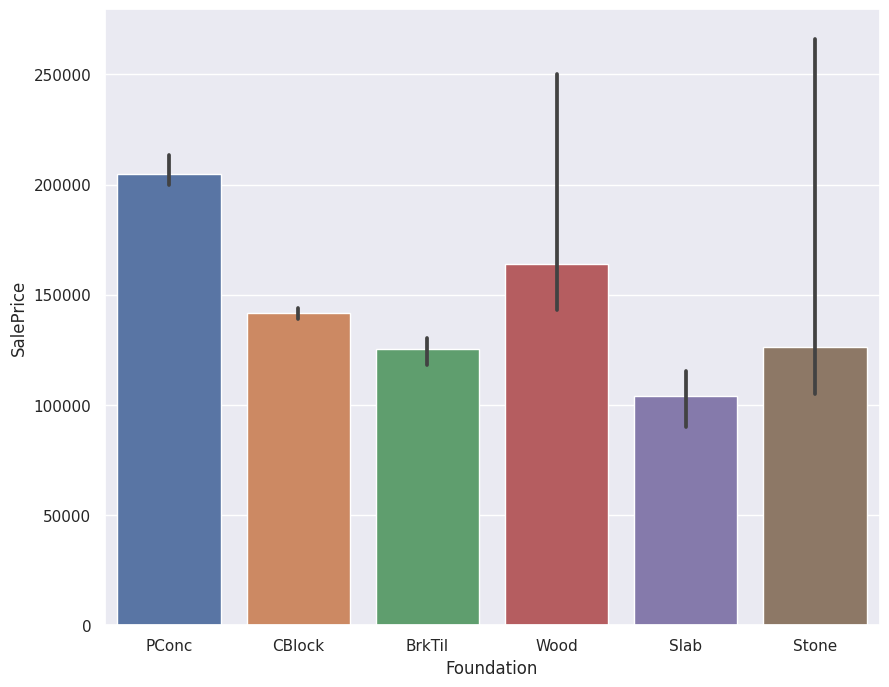

In [ ]:
sns.barplot(data=train, x='Foundation', y='SalePrice', estimator='median');

As for the Foundation, houses using PConc (Poured Concrete) are highly priced over the others.

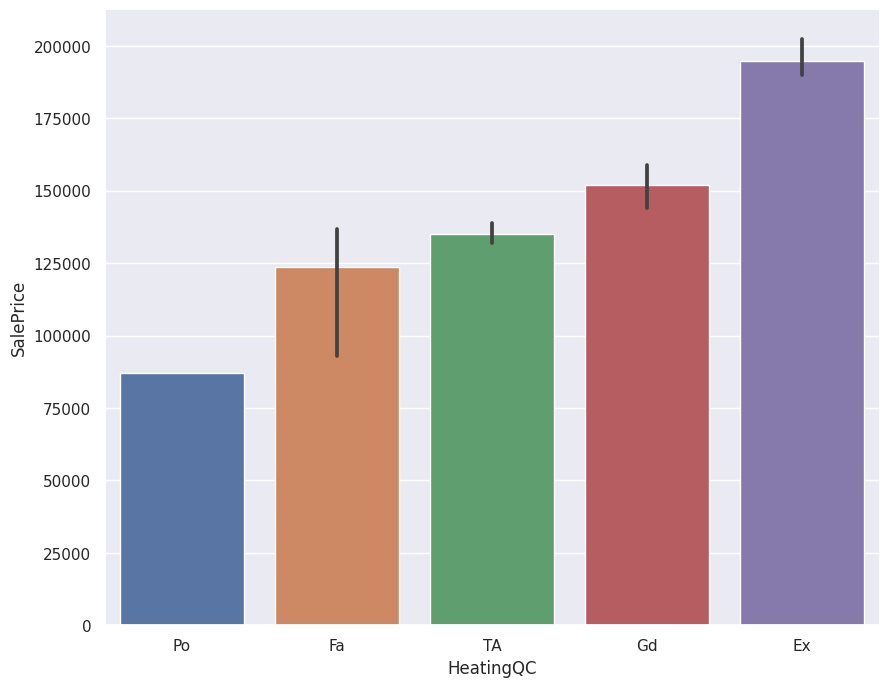

In [ ]:
sns.barplot(data=train, x='HeatingQC', y='SalePrice', estimator='median', order=['Po', 'Fa', 'TA', 'Gd', 'Ex']);

Again, the better the HeatingQual, the higher the SalePrice.

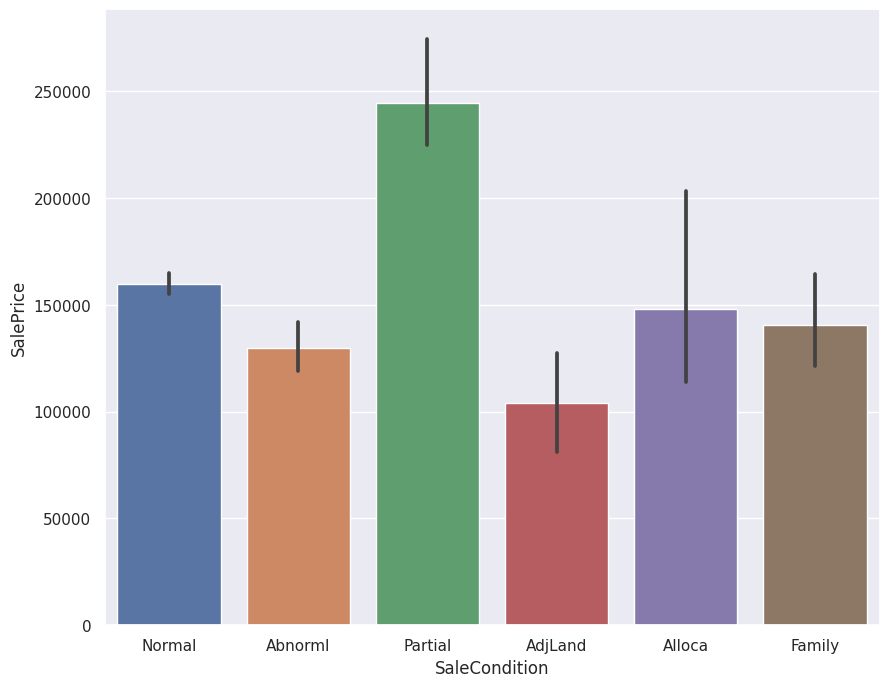

In [ ]:
sns.barplot(data=train, x='SaleCondition', y='SalePrice', estimator='median');

Partially completed houses are more expensive than the others, because it's associated with new house.

Now, let's prepare our data for the machine learning model.

## Data Preprocessing

In [ ]:
all_data = pd.concat([train, test])
all_data.set_index('Id', inplace=True)

### Outliers

In [ ]:
all_data.drop(all_data[all_data['GrLivArea'] > 4500].index, inplace=True)

### Missing Data

In [ ]:
def print_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum() / len(df) * 100).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data[missing_data['Total'] > 0]

print_missing_data_table(all_data)

,Total,Percent
PoolQC,2907,99.691358
MiscFeature,2811,96.399177
Alley,2718,93.209877
Fence,2345,80.418381
SalePrice,1458,50.000000
FireplaceQu,1420,48.696845
LotFrontage,486,16.666667
GarageCond,159,5.452675
GarageFinish,159,5.452675
GarageQual,159,5.452675


In [ ]:
all_data.drop(['PoolQC', 'MiscFeature', 'Alley', 'Fence'], axis=1, inplace=True)

In [ ]:
all_data.loc[333, ['BsmtFinType2', 'BsmtUnfSF']] = ('Rec', 0)
all_data.loc[[2218, 2219], 'BsmtQual'] = 'TA'
all_data.loc[[2041, 2186, 2525], 'BsmtCond'] = 'TA'
all_data.loc[[949, 1488, 2349], 'BsmtExposure'] = 'No'

In [ ]:
all_data.loc[2127, ['GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']] = (1979, 'Unf', 'TA', 'TA')
all_data.loc[2577, 'GarageType'] = np.nan

In [ ]:
idx = (all_data["MasVnrArea"] > 0) & ((all_data["MasVnrType"] == "None") | (all_data["MasVnrType"].isnull()))
all_data.loc[idx, "MasVnrType"] = "BrkFace"

### Numerical Data

In [ ]:
all_num_data = all_data.select_dtypes(include=[np.number])
print_missing_data_table(all_num_data)

,Total,Percent
SalePrice,1458,50.000000
LotFrontage,486,16.666667
GarageYrBlt,158,5.418381
MasVnrArea,23,0.788752
BsmtHalfBath,2,0.068587
BsmtFullBath,2,0.068587
TotalBsmtSF,1,0.034294
GarageCars,1,0.034294
GarageArea,1,0.034294
BsmtFinSF1,1,0.034294


In [ ]:
for key, group in all_data['LotFrontage'].groupby(all_data['Neighborhood']):
    all_data.loc[(all_data['Neighborhood'] == key) & (all_data['LotFrontage'].isnull()), 'LotFrontage'] = group.median()

In [ ]:
all_data["BsmtFinSF1"].fillna(0, inplace=True)
all_data["BsmtFinSF2"].fillna(0, inplace=True)
all_data["BsmtUnfSF"].fillna(0, inplace=True)
all_data["TotalBsmtSF"].fillna(0, inplace=True)
all_data["BsmtHalfBath"].fillna(0, inplace=True)
all_data["BsmtFullBath"].fillna(0, inplace=True)
all_data["GarageCars"].fillna(0, inplace=True)
all_data["GarageArea"].fillna(0, inplace=True)
all_data["GarageYrBlt"].fillna(0, inplace=True)
all_data["MasVnrArea"].fillna(0, inplace=True)

### Categorical Data

In [ ]:
all_cat_data = all_data.select_dtypes(exclude=[np.number])
print_missing_data_table(all_cat_data)

,Total,Percent
FireplaceQu,1420,48.696845
GarageCond,158,5.418381
GarageQual,158,5.418381
GarageFinish,158,5.418381
GarageType,158,5.418381
BsmtExposure,79,2.709191
BsmtFinType1,79,2.709191
BsmtCond,79,2.709191
BsmtQual,79,2.709191
BsmtFinType2,79,2.709191


In [ ]:
def preprocess_categorical(df, col, fill_na=None, categories=None, ordered=None):
    if fill_na is not None:
        df[col].fillna(fill_na, inplace=True)
    df[col] = pd.Categorical(df[col], categories=categories, ordered=ordered)
    df[col] = df[col].cat.codes
    return df

In [ ]:
qual_col = ['ExterQual', 'ExterCond', 'BsmtQual', 'BsmtCond', 'HeatingQC', 'KitchenQual', 'FireplaceQu', 'GarageQual', 'GarageCond']
qual_cat = ['None', 'Po', 'Fa', 'TA', 'Gd', 'Ex']

for col in qual_col:
    all_data = preprocess_categorical(all_data, col, fill_na='None', categories=qual_cat, ordered=True)

In [ ]:
bsmt_col = ['BsmtFinType1', 'BsmtFinType2']
bsmt_cat = ['None', 'Unf', 'LwQ', 'Rec', 'BLQ', 'ALQ', 'GLQ']

for col in bsmt_col:
    all_data = preprocess_categorical(all_data, col, fill_na='None', categories=bsmt_cat, ordered=True)

In [ ]:
all_data = preprocess_categorical(all_data, 'GarageFinish', fill_na='None', categories=['None', 'Unf', 'Rfn', 'Fin'], ordered=True)
all_data = preprocess_categorical(all_data, 'GarageType', fill_na='None')
all_data = preprocess_categorical(all_data, 'BsmtExposure', fill_na='None', categories=['None', 'No', 'Mn', 'Av', 'Gd'], ordered=True)
all_data = preprocess_categorical(all_data, 'MasVnrType', fill_na='None')
all_data = preprocess_categorical(all_data, 'MSZoning', fill_na='RL')
all_data = preprocess_categorical(all_data, 'Functional', fill_na='Typ', categories=['Sal', 'Sev', 'Maj2', 'Maj1', 'Mod', 'Min2', 'Min1', 'Typ'], ordered=True)
all_data = preprocess_categorical(all_data, 'Utilities', fill_na='AllPub')
all_data = preprocess_categorical(all_data, 'Electrical', fill_na='SBrkr')
all_data = preprocess_categorical(all_data, 'Exterior1st', fill_na='Other')
all_data = preprocess_categorical(all_data, 'Exterior2nd', fill_na='Other')
all_data = preprocess_categorical(all_data, 'SaleType', fill_na='Oth')

In [ ]:
cat_cols = ['Street', 'LotShape', 'LandContour', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
            'HouseStyle', 'RoofStyle', 'RoofMatl', 'Foundation', 'Heating', 'CentralAir', 'PavedDrive', 'SaleCondition']

for col in cat_cols:
    all_data = preprocess_categorical(all_data, col)

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 1 to 2919
Data columns (total 76 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     2916 non-null   int64  
 1   MSZoning       2916 non-null   int8   
 2   LotFrontage    2916 non-null   float64
 3   LotArea        2916 non-null   int64  
 4   Street         2916 non-null   int8   
 5   LotShape       2916 non-null   int8   
 6   LandContour    2916 non-null   int8   
 7   Utilities      2916 non-null   int8   
 8   LotConfig      2916 non-null   int8   
 9   LandSlope      2916 non-null   int8   
 10  Neighborhood   2916 non-null   int8   
 11  Condition1     2916 non-null   int8   
 12  Condition2     2916 non-null   int8   
 13  BldgType       2916 non-null   int8   
 14  HouseStyle     2916 non-null   int8   
 15  OverallQual    2916 non-null   int64  
 16  OverallCond    2916 non-null   int64  
 17  YearBuilt      2916 non-null   int64  
 18  YearRemo

## Feature Engineering

In [ ]:
all_data["IsRegularLotShape"] = (all_data["LotShape"] == "Reg") * 1
all_data["IsLandLevel"] = (all_data["LandContour"] == "Lvl") * 1
all_data["IsLandSlopeGentle"] = (all_data["LandSlope"] == "Gtl") * 1
all_data["IsElectricalSBrkr"] = (all_data["Electrical"] == "SBrkr") * 1
all_data["IsGarageDetached"] = (all_data["GarageType"] == "Detchd") * 1
all_data["IsPavedDrive"] = (all_data["PavedDrive"] == "Y") * 1
all_data["Remodeled"] = (all_data["YearRemodAdd"] != all_data["YearBuilt"]) * 1
all_data["RecentRemodel"] = (all_data["YearRemodAdd"] == all_data["YrSold"]) * 1
all_data["VeryNewHouse"] = (all_data["YearBuilt"] == all_data["YrSold"]) * 1
all_data["Has2ndFloor"] = (all_data["2ndFlrSF"] > 0) * 1
all_data["HasPool"] = (all_data["PoolArea"] > 0) * 1
all_data["HasMasVnr"] = (all_data["MasVnrArea"] > 0) * 1
all_data["HasWoodDeck"] = (all_data["WoodDeckSF"] > 0) * 1
all_data["HasOpenPorch"] = (all_data["OpenPorchSF"] > 0) * 1
all_data["HasEnclosedPorch"] = (all_data["EnclosedPorch"] > 0) * 1
all_data["Has3SsnPorch"] = (all_data["3SsnPorch"] > 0) * 1
all_data["HasScreenPorch"] = (all_data["ScreenPorch"] > 0) * 1

In [ ]:
all_data["SeasonSold"] = all_data["MoSold"].map({12: 0, 1: 0, 2: 0, 3: 1, 4: 1, 5: 1, 6: 2, 7: 2, 8: 2, 9: 3, 10: 3, 11: 3}).astype(int)
all_data["HighSeason"] = all_data["MoSold"].map({1: 0, 2: 0, 3: 0, 4: 1, 5: 1, 6: 1, 7: 1, 8: 0, 9: 0, 10: 0, 11: 0, 12: 0}).astype(int)
all_data["NewerDwelling"] = all_data["MSSubClass"].map({20: 1, 30: 0, 40: 0, 45: 0,50: 0, 60: 1, 70: 0, 75: 0, 80: 0, 85: 0, 90: 0,
                                                        120: 1, 150: 0, 160: 1, 180: 0, 190: 0}).astype(int)

In [ ]:
all_data["Completed"] = all_data['SaleCondition'].replace({"Abnorml" : 0, "Alloca" : 0, "AdjLand" : 0, "Family" : 0, "Normal" : 0, "Partial" : 1})
all_data["GoodHeating"] = all_data['HeatingQC'].replace({'Ex': 0, 'Gd': 0, 'TA': 0, 'Fa': 1, 'Po': 1})

In [ ]:
area_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea',
             'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'LowQualFinSF', 'PoolArea']

all_data["TotalArea"] = all_data[area_cols].sum(axis=1)
all_data["TotalArea1st2nd"] = all_data["1stFlrSF"] + all_data["2ndFlrSF"]

all_data["Age"] = 2010 - all_data["YearBuilt"]
all_data["TimeSinceSold"] = 2010 - all_data["YrSold"]
all_data["YearsSinceRemodel"] = all_data["YrSold"] - all_data["YearRemodAdd"]

In [ ]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2916 entries, 1 to 2919
Columns: 103 entries, MSSubClass to YearsSinceRemodel
dtypes: float64(13), int64(49), int8(41)
memory usage: 1.6 MB


Then, we'll train the data using Linear Regression and Lasso Regression.

## Model Training and Evaluation

In [ ]:
num_cols = ['LotFrontage', 'LotArea', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF',
            '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF',
            'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal']
df_to_scale = all_data[num_cols]

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

scaled_data = scaler.fit_transform(df_to_scale)
scaled_df = pd.DataFrame(scaled_data, columns=num_cols)
all_data[num_cols] = scaled_df

In [ ]:
train_new = all_data[all_data['SalePrice'].notnull()]
test_new = all_data[all_data['SalePrice'].isnull()]
train_new.shape, test_new.shape

((1458, 103), (1458, 103))

In [ ]:
X = train_new.drop(['SalePrice'], axis=1)
y = np.log(train_new['SalePrice'])
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=.3)

### Linear Regression

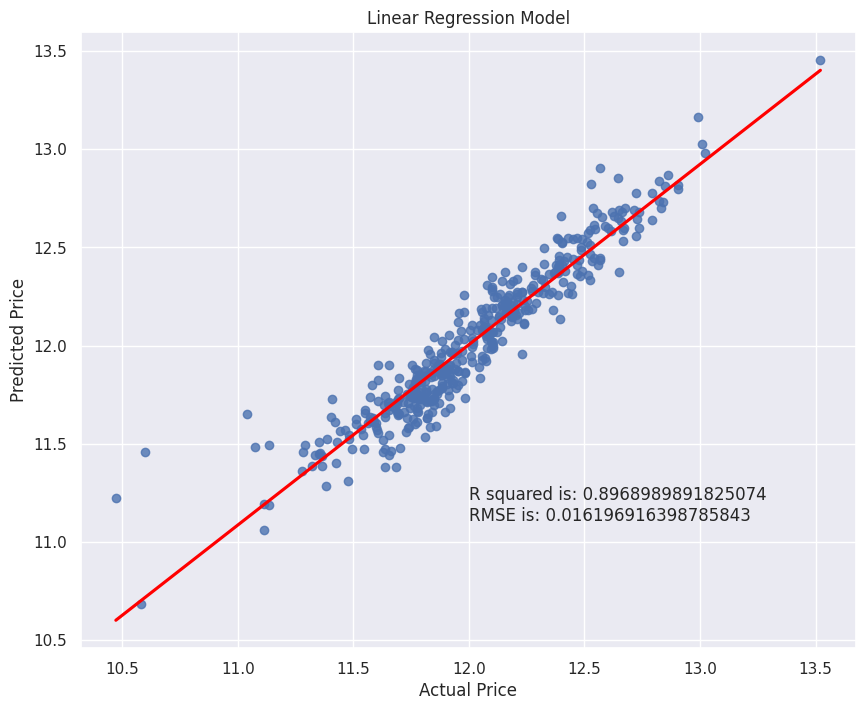

In [ ]:
lr = LinearRegression()
model = lr.fit(X_train, y_train)
predictions = model.predict(X_test)

sns.regplot(x=y_test, y=predictions, ci=None, line_kws={'color': 'red'})
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Linear Regression Model');

overlay = 'R squared is: {}\nRMSE is: {}\n'.format(model.score(X_test, y_test), mean_squared_error(y_test, predictions))
plt.annotate(text=overlay, xy=(12, 11));

Linear Regression model achieves 89% accuracy.

### Lasso Regression

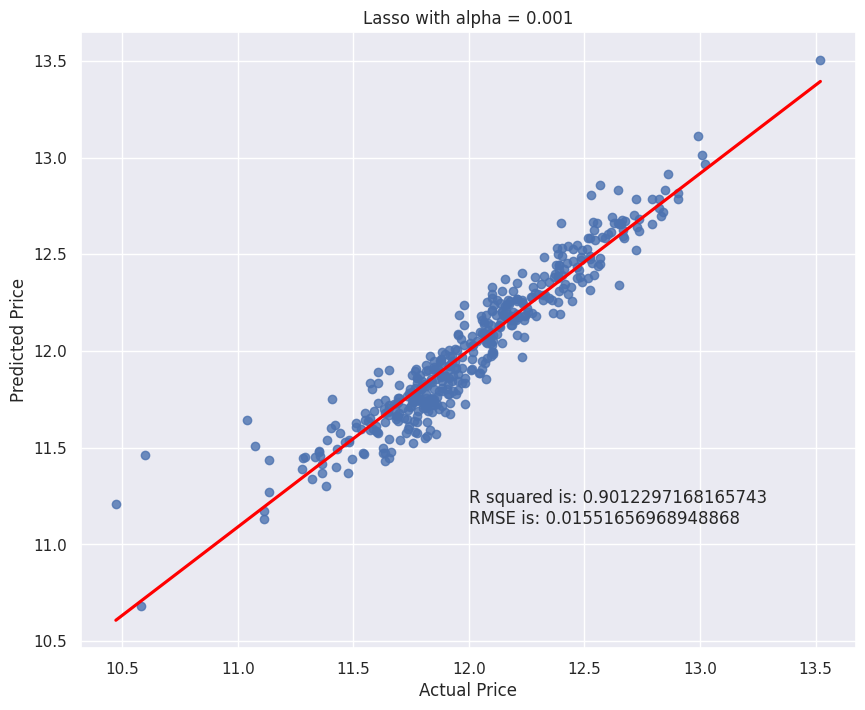

In [ ]:
alpha = 0.001
lasso = Lasso(alpha=alpha, max_iter=5000)
lasso_model = lasso.fit(X_train, y_train)
preds_lasso = lasso_model.predict(X_test)

sns.regplot(x=y_test, y=preds_lasso, ci=None, line_kws={'color': 'red'})
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Lasso with alpha = {}'.format(alpha))

overlay = 'R squared is: {}\nRMSE is: {}\n'.format(lasso_model.score(X_test, y_test), mean_squared_error(y_test, preds_lasso))
plt.annotate(text=overlay, xy=(12, 11));

Using Lasso Regression, we achieve a slightly better result of 90% accuracy.